In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset, random_split, Dataset
from torch.nn.utils.rnn import pad_sequence
import h5py
import numpy as np
import matplotlib.pyplot as plt
import copy

## Dataset Definition

In [2]:
class FacialFeaturesDataset(Dataset):
    def __init__(self, h5_file):
        self.h5_file = h5_file
        with h5py.File(h5_file, 'r') as file:
            self.keys = list(file.keys())
            self.labels = [file[key].attrs['label'] for key in self.keys]
            
    def __len__(self):
        return len(self.keys)
    
    def __getitem__(self, idx):
        with h5py.File(self.h5_file, 'r') as file:
            group_key = self.keys[idx]
            features = file[group_key]['features'][:]
            label = file[group_key].attrs['label']
        return torch.tensor(features, dtype=torch.float), torch.tensor(label, dtype=torch.long)

# We need this because our video clips length are different
def collate_fn(batch):
    features, labels = zip(*batch)
    # Pad the sequences to have the same length
    features_padded = pad_sequence(features, batch_first=True)
    labels = torch.tensor(labels, dtype=torch.long)
    return features_padded, labels

## Model Definition

In [3]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.gru =  nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        
        self.linear = nn.Linear(hidden_dim, output_dim)

        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        
        # out, _ = self.lstm(x, (h0, c0))
        out, _ = self.gru(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.linear(out[:, -1, :])
        return out

In [4]:
def validate(model, data_loader, criterion, device):
    model.eval() 
    total_loss = 0
    total_correct = 0
    with torch.no_grad():  
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_correct += (predicted == labels).sum().item()
    avg_loss = total_loss / len(data_loader)
    accuracy = total_correct / len(data_loader.dataset)
    return avg_loss, accuracy


## Execution

In [5]:
############################################
# Params
num_epochs = 50
learning_rate = 0.0001
hidden_size = 2048
num_layers = 3

train_ratio = 0.8
val_ratio = 0.1
# Test ratio is the rest
patience = 10
batch_size = 64


# Speed Params
num_workers = 0

############################################

# Model instantiation
model = LSTMClassifier(input_dim=2048, hidden_dim=hidden_size, output_dim=3, num_layers=num_layers)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=patience, factor=0.1, verbose=True)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

dataset = FacialFeaturesDataset('facial_features-CMU_MOSEI_30.h5')

total_size = len(dataset)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn, num_workers=num_workers)

c:\Users\jonec\miniconda3\envs\SUTD\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [6]:
train_losses = []
val_losses = []
best_val_loss = float('inf')
best_model_weights = copy.deepcopy(model.state_dict()) 

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)
        
        outputs = model(features)
        loss = criterion(outputs, labels)
        total_train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    avg_train_loss = total_train_loss / len(train_loader)
    val_loss, val_accuracy = validate(model, val_loader, criterion, device)
    
    train_losses.append(avg_train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    
    if val_loss < best_val_loss:
        # print(f"Validation loss decreased ({best_val_loss:.6f} --> {val_loss:.6f}). Saving model ...")
        best_val_loss = val_loss
        best_model_weights = copy.deepcopy(model.state_dict())
        # Save model (optional)
        torch.save(model.state_dict(), 'best_model_GRU_30.pth')
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}')


Epoch [1/50], Training Loss: 1.0906, Validation Loss: 1.0794, Validation Accuracy: 0.4291
Epoch [2/50], Training Loss: 1.0448, Validation Loss: 1.0432, Validation Accuracy: 0.4695
Epoch [3/50], Training Loss: 1.0155, Validation Loss: 1.0257, Validation Accuracy: 0.4914
Epoch [4/50], Training Loss: 0.9914, Validation Loss: 1.0207, Validation Accuracy: 0.4928
Epoch [5/50], Training Loss: 0.9671, Validation Loss: 1.0216, Validation Accuracy: 0.5003
Epoch [6/50], Training Loss: 0.9450, Validation Loss: 1.0271, Validation Accuracy: 0.5065
Epoch [7/50], Training Loss: 0.9153, Validation Loss: 0.9859, Validation Accuracy: 0.5250
Epoch [8/50], Training Loss: 0.8982, Validation Loss: 1.0091, Validation Accuracy: 0.5243
Epoch [9/50], Training Loss: 0.8583, Validation Loss: 1.0055, Validation Accuracy: 0.5284
Epoch [10/50], Training Loss: 0.8252, Validation Loss: 0.9710, Validation Accuracy: 0.5730
Epoch [11/50], Training Loss: 0.7903, Validation Loss: 1.0357, Validation Accuracy: 0.5284
Epoch [1

## Plotting training vs validation losses

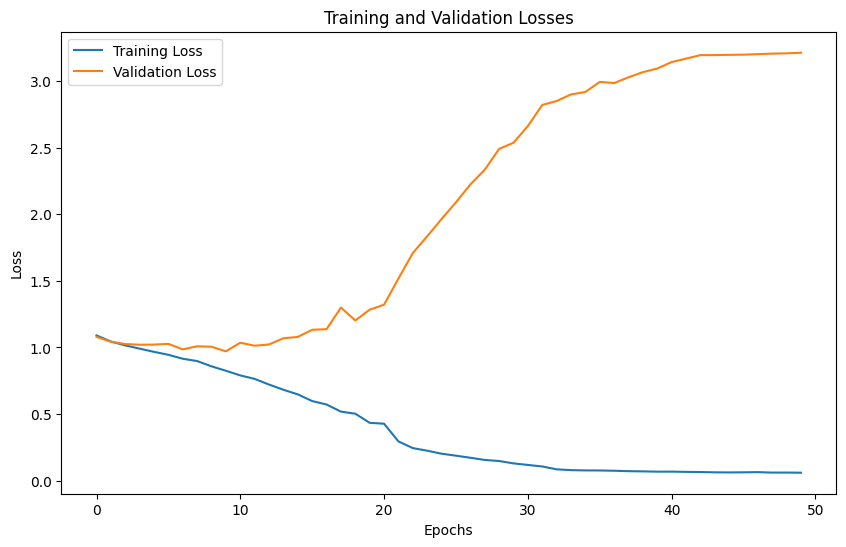

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Testing model

In [10]:
model.load_state_dict(best_model_weights)
# model.load_state_dict(torch.load('best_model.pth'))
test_loss, test_accuracy = validate(model, test_loader, criterion, device)
print(f'Lowest validation loss: {best_val_loss}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')


Lowest validation loss: 0.9709818751915641, Test Loss: 1.0162, Test Accuracy: 0.5428
